## Domaci zadatak iz prepoznavanja oblika

### Zadatak 3. Opcija 2.

### Uvoz neophodnih biblioteka

In [100]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

### Uvoz i analiza baze podataka

In [101]:
db = fetch_ucirepo(id=697) 

df = pd.DataFrame(db.data.features, columns=db.data.feature_names)
df['Target'] = db.data.targets
#Broj odbiraka u svakoj klasi
print(df['Target'].value_counts())

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64


S obzirom da podaci nisu balansirani, radimo undersampling podataka:

In [102]:
X = df.drop('Target', axis=1)
y = df['Target']

#Razvrstavamo podatke prema klasi
class_0 = df[df['Target'] == 'Graduate'] 
class_1 = df[df['Target'] == 'Enrolled']
class_2 = df[df['Target'] == 'Dropout'] 

#Undersample-ujemo podatke iz klasa Graduate i Dropout
class_0_undersampled = resample(class_0, replace=False, n_samples=len(class_1), random_state=42)  
class_2_undersampled = resample(class_2, replace=False, n_samples=len(class_1), random_state=42)

#Spajamo podatke u novu bazu podataka
undersampled_data = pd.concat([class_0_undersampled, class_1, class_2_undersampled])
df = undersampled_data
print(df['Target'].value_counts())

Graduate    794
Enrolled    794
Dropout     794
Name: Target, dtype: int64


Prebacujemo kolonu Target iz tipa object u int:

In [103]:
df.Target = df['Target'].replace('Graduate', 0)
df.Target = df['Target'].replace('Enrolled', 1)
df.Target = df['Target'].replace('Dropout', 2)

### Koeficijent korelacije i redukcija na 10 dimenzija

In [104]:
#Spearman-ov koeficijent korelacije
spearman_R = df.corr(method='spearman')
print('Spearman-ov koeficijent korelacije obelezja sa klasom:')
print(spearman_R[['Target']])
print('-------------------------------------------------------------------')

#Izbacujemo kolonu Target da bi nasli 10 obelezja sa najvecim koef. korelacije sa Target
correlation_without_target = spearman_R['Target'].drop('Target')
data_reduced = correlation_without_target.abs().sort_values(ascending=False).head(10)

print('Obelezja koja cine redukovanu bazu podataka i koeficijent korelacije:')
print(data_reduced)
df_reduced = df[data_reduced.index.tolist() + ['Target']]


Spearman-ov koeficijent korelacije obelezja sa klasom:
                                                  Target
Marital Status                                  0.099346
Application mode                                0.182605
Application order                              -0.115033
Course                                         -0.024282
Daytime/evening attendance                     -0.066072
Previous qualification                          0.131088
Previous qualification (grade)                 -0.083118
Nacionality                                    -0.021887
Mother's qualification                          0.017677
Father's qualification                         -0.017659
Mother's occupation                            -0.039655
Father's occupation                            -0.044201
Admission grade                                -0.107154
Displaced                                      -0.094915
Educational special needs                       0.000000
Debtor                           

### Podela na trening i test skup

In [105]:
#X su podaci, y je Target
X = df_reduced.drop('Target', axis=1) 
y = df_reduced['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Redukcija na n=2 dimenzije

In [106]:
#Normalizacija trening skupa
X_norm = X_train - np.mean(X_train , axis = 0)
X_norm /= np.std(X_train, axis = 0)

#Normalizujemo podatke iz test skupa na osnovu trening skupa
#Ovo moze da se primeni i nad pojedinacnim podacima koji bi pristizali
X_norm_test = X_test - np.mean(X_train , axis = 0)
X_norm_test /= np.std(X_train, axis = 0)

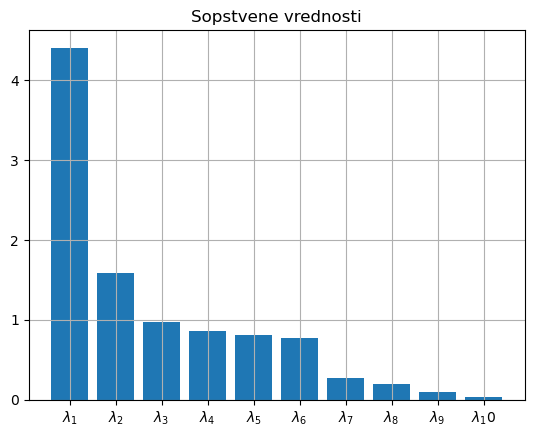

In [107]:
#Racunanje kovarijacione matrice Sx i sopstvenih vrednosti i vektora
Sx = np.cov(X_norm.T)
eigval, eigvec = np.linalg.eig(Sx)

idx = np.argsort(eigval)[::-1]
eigval = eigval[idx]
eigvec = eigvec[:, idx]

plt.figure()
plt.bar(np.arange(len(eigval))+1, eigval)
plt.xticks(ticks=[1, 2, 3, 4, 5, 6 , 7, 8, 9, 10], labels=['$\lambda_1$','$\lambda_2$', '$\lambda_3$', '$\lambda_4$', '$\lambda_5$', '$\lambda_6$', '$\lambda_7$', '$\lambda_8$', '$\lambda_9$', '$\lambda_10$'])
plt.grid()
plt.title('Sopstvene vrednosti')
plt.show()

In [108]:
#Redukcija na n=2 prema najvecem lambda
no_comp = 2
A = eigvec[:, :no_comp]

Y = A.T @ X_norm.T
Y = Y.T

#Baza sa redukovanim dimenzijama i Targetom za svaki podatak
principal_df = pd.concat([Y , y_train] , axis = 1)
principal_df.columns = ['PC1', 'PC2', 'Target']

#Razvrstavamo po klasama (koloni Target) da bi kasnije napravili kvadratne klasifikatore
df_target_0 = principal_df[principal_df['Target'] == 0]
df_target_1 = principal_df[principal_df['Target'] == 1]
df_target_2 = principal_df[principal_df['Target'] == 2]

#Dataframe-ove pretvaramo u matrice
X0 = np.vstack((df_target_0['PC1'].values, df_target_0['PC2'].values))
X1 = np.vstack((df_target_1['PC1'].values, df_target_1['PC2'].values))
X2 = np.vstack((df_target_2['PC1'].values, df_target_2['PC2'].values))

Prikaz podataka nakon redukcije na 2 dimenzije:

Text(0, 0.5, 'PC2')

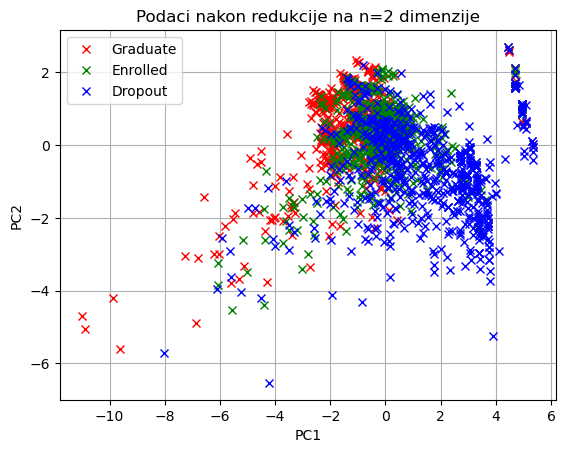

In [109]:
plt.figure()
plt.plot(X0[0,:],X0[1,:], 'rx', label='Graduate')
plt.plot(X1[0,:],X1[1,:], 'gx', label='Enrolled')
plt.plot(X2[0,:],X2[1,:], 'bx', label='Dropout')
plt.grid()
plt.legend()
plt.title('Podaci nakon redukcije na n=2 dimenzije')
plt.xlabel('PC1')
plt.ylabel('PC2')

### Projektovanje kvadratnog klasifikatora

Pravimo tri kvadratna klasifikatora, između klasa 0 i 1, klasa 0 i 2 i klasa 1 i 2. Kasnije pravimo funkciju koja ce na osnovu ovih kvadratnih klasifikatora da vraca vrednost 0, 1 ili 2.

In [110]:
#Broj podataka u svakoj klasi
N0 = len(df_target_0)
N1 = len(df_target_1)
N2 = len(df_target_2)
N = N0 + N1 + N2

Text(0.5, 1.0, 'Kvadratni klasifikator na bazi željenih izlaza')

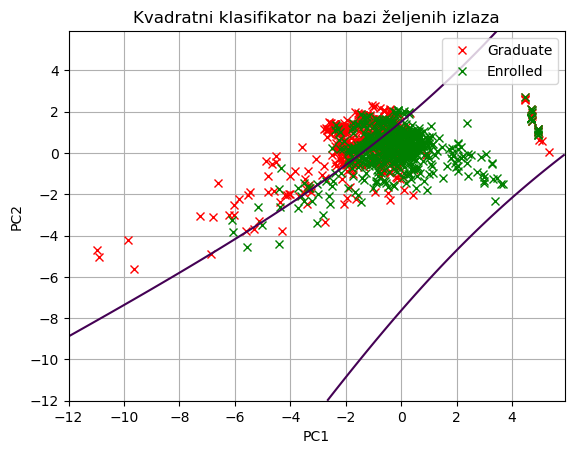

In [111]:
#Izmedju 0 i 1 -> Graduate i Enrolled

#x0 je niz kome je prvih N0 elemenata -1, a preostalih N1 ima vrednost 1
x0 = np.ones((1,N0+N1))
x0[0,0:N0] = x0[0,0:N0]*(-1)

#X0_w sadrzi izracunate clanove na osnovu podataka iz klase X0, inverovani su clanovi (imaju -)
X0_w = np.zeros((5,N0))
X0_w[0:2,:] = -X0
X0_w[2:4,:] = -X0*X0
X0_w[4,:] = -X0[0,:]*X0[1,:]

#X1_w sadrzi izracunate clanove na osnovu podataka iz klase X1
X1_w = np.zeros((5,N1))
X1_w[0:2,:] = X1
X1_w[2:4,:] = X1*X1
X1_w[4,:] = X1[0,:]*X1[1,:]

#Spajamo podatke
X = np.concatenate((X0_w,X1_w),axis=1)
U = np.concatenate((x0,X),axis=0)

#Zeljeni izlazi
Gamma = np.ones((1,N0+N1)).T

#Racunamo koeficijente
W01 = np.linalg.inv(U@U.T)@U@Gamma

#Prikaz klasifikacione linije
x1 = np.arange(-12,6,0.1)
x2 = np.arange(-12,6,0.1)

h01 = np.zeros((len(x1),len(x1)))

for i in range(0,len(x1)):
    for j in range(0,len(x2)):
        h01[i,j] = W01[0]+W01[1]*x1[i]+W01[2]*x2[j]+W01[3]*x1[i]**2+W01[4]*x2[j]**2+W01[5]*x1[i]*x2[j]

plt.figure()
plt.plot(X0[0,:],X0[1,:],'rx', label='Graduate')
plt.plot(X1[0,:],X1[1,:],'gx', label='Enrolled')
plt.contour(x1,x2,h01.T,levels=[0])
plt.legend()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kvadratni klasifikator na bazi željenih izlaza')

Text(0.5, 1.0, 'Kvadratni klasifikator na bazi željenih izlaza')

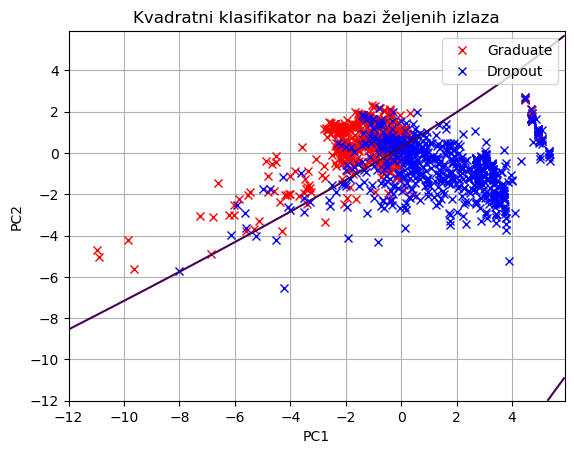

In [112]:
#Izmedju 0 i 2 -> Graduate i Dropout

#Sve ponovljeno samo za druge podatke

x0 = np.ones((1,N0+N2))
x0[0,0:N0] = x0[0,0:N0]*(-1)


X0_w = np.zeros((5,N0))
X0_w[0:2,:] = -X0
X0_w[2:4,:] = -X0*X0
X0_w[4,:] = -X0[0,:]*X0[1,:]


X2_w = np.zeros((5,N2))
X2_w[0:2,:] = X2
X2_w[2:4,:] = X2*X2
X2_w[4,:] = X2[0,:]*X2[1,:]

X = np.concatenate((X0_w,X2_w),axis=1)

U = np.concatenate((x0,X),axis=0)

Gamma = np.ones((1,N0+N2)).T

W02 = np.linalg.inv(U@U.T)@U@Gamma

x1 = np.arange(-12,6,0.1)
x2 = np.arange(-12,6,0.1)

h02 = np.zeros((len(x1),len(x1)))

for i in range(0,len(x1)):
    for j in range(0,len(x2)):
        h02[i,j] = W02[0]+W02[1]*x1[i]+W02[2]*x2[j]+W02[3]*x1[i]**2+W02[4]*x2[j]**2+W02[5]*x1[i]*x2[j]
   

plt.figure()
plt.plot(X0[0,:],X0[1,:],'rx', label='Graduate')
plt.plot(X2[0,:],X2[1,:],'bx', label='Dropout')
plt.contour(x1,x2,h02.T,levels=[0])
plt.legend()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kvadratni klasifikator na bazi željenih izlaza')

Text(0.5, 1.0, 'Kvadratni klasifikator na bazi željenih izlaza')

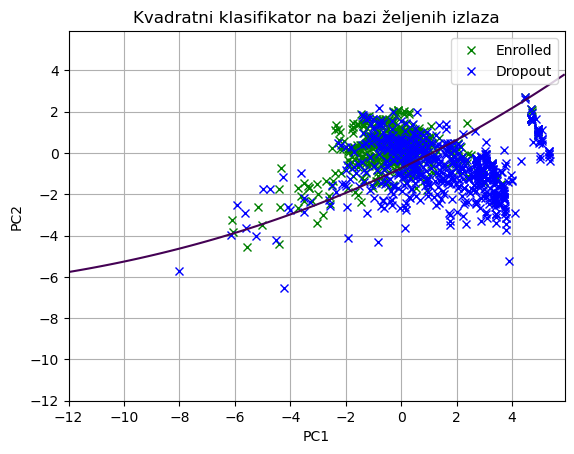

In [114]:
#Izmedju 1 i 2 -> Enrolled i Dropout

#Sve ponovljeno samo za druge podatke

x0 = np.ones((1,N1+N2))
x0[0,0:N1] = x0[0,0:N1]*(-1)


X1_w = np.zeros((5,N1))
X1_w[0:2,:] = -X1
X1_w[2:4,:] = -X1*X1
X1_w[4,:] = -X1[0,:]*X1[1,:]


X2_w = np.zeros((5,N2))
X2_w[0:2,:] = X2
X2_w[2:4,:] = X2*X2
X2_w[4,:] = X2[0,:]*X2[1,:]

X = np.concatenate((X1_w,X2_w),axis=1)

U = np.concatenate((x0,X),axis=0)

Gamma = np.ones((1,N1+N2)).T

W12 = np.linalg.inv(U@U.T)@U@Gamma

x1 = np.arange(-12,6,0.1)
x2 = np.arange(-12,6,0.1)

h12 = np.zeros((len(x1),len(x1)))

for i in range(0,len(x1)):
    for j in range(0,len(x2)):
        h12[i,j] = W12[0]+W12[1]*x1[i]+W12[2]*x2[j]+W12[3]*x1[i]**2+W12[4]*x2[j]**2+W12[5]*x1[i]*x2[j]
   

plt.figure()
plt.plot(X1[0,:],X1[1,:],'gx', label='Enrolled')
plt.plot(X2[0,:],X2[1,:],'bx', label='Dropout')
plt.contour(x1,x2,h12.T,levels=[0])
plt.legend()
plt.grid()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Kvadratni klasifikator na bazi željenih izlaza')

Na narednom grafiku prikazani su svi podaci i klasifikacione linije dobijene kvadratnim klasifikatorima na bazi zeljenih izlaza. Zuta boja razdvaja crvene i zelene podatke (Graduate i Enrolled), ljubicasta razdvaja crvene i plave podatke (Graduate i Dropout), a tirkizna zelene i plave (Enrolled i Dropout), simbolicno. 


Text(0.5, 1.0, 'Kvadratni klasifikator na bazi željenih izlaza')

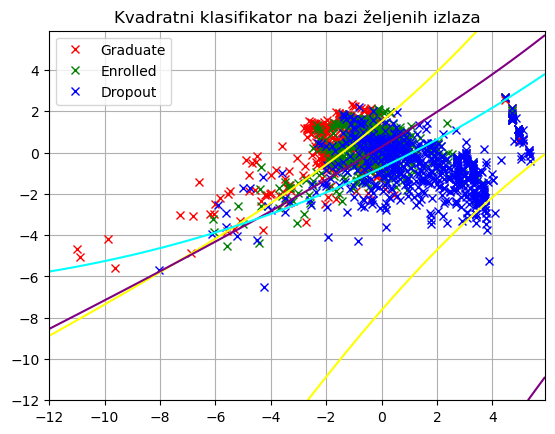

In [117]:
plt.figure()
plt.plot(X0[0,:],X0[1,:], 'rx', label='Graduate')
plt.plot(X1[0,:],X1[1,:], 'gx', label='Enrolled')
plt.plot(X2[0,:],X2[1,:], 'bx', label='Dropout')
plt.contour(x1,x2,h01.T,levels=[0],colors='yellow')
plt.contour(x1,x2,h02.T,levels=[0],colors='purple')
plt.contour(x1,x2,h12.T,levels=[0],colors='cyan')
plt.grid()
plt.legend()
plt.title('Kvadratni klasifikator na bazi željenih izlaza')

### Kvadratni klasifikator classify(X)

Funkcija classify(X) na osnovu koordinata PC1 i PC2 vraca klasu kojoj podatak pripada. Realizovana je tako da posmatra vrednosti h01 i h02 -> ako smo iznad zute linije na prethodnom grafiku, klasifikujemo kao Graduate, ako smo ispod plave linije klasifikujemo kao Dropout, ako smo izmedju kao Enrolled.

In [69]:
def classify(X):
    h01 = W01[0]+W01[1]*X[0]+W01[2]*X[1]+W01[3]*X[0]**2+W01[4]*X[1]**2+W01[5]*X[0]*X[1]
    h12 = W12[0]+W12[1]*X[0]+W12[2]*X[1]+W12[3]*X[0]**2+W12[4]*X[1]**2+W12[5]*X[0]*X[1]
    if h01 < 0:
        return 0
    if h12 > 0:
        return 2
    else:
        return 1

In [118]:
#Testiranje funkcije
print(classify([2,-2]))

2


### Matrica konfuzije na obucavajucem skupu

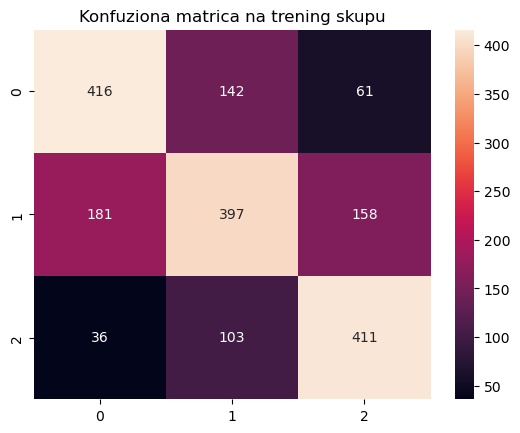

0.6425196850393701


In [127]:
#Koristimo vrednosti nakon redukcije dimenzija, pretvaramo df u niz
Y_arr = np.vstack((principal_df['PC1'].values, principal_df['PC2'].values))
Y_arr = Y_arr.T
Y_pred = []

#Koristimo funkciju classify na svakom podatku
for i in range(len(Y_arr)):
    Y_pred.append(classify(Y_arr[i]))

    
#Konfuziona matrica
cm_train = confusion_matrix(Y_pred, y_train)

#Prikaz
plt.figure()
sns.heatmap(cm_train, annot=True, fmt='g')
plt.title('Konfuziona matrica na trening skupu')
plt.show()

### Matrica konfuzije na test skupu

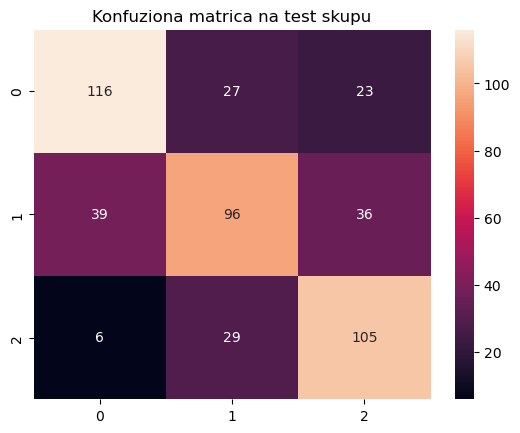

In [126]:
#Redukujemo dimenzije obucavajucem skupu
Y_test = A.T @ X_norm_test.T
Y_test = Y_test.T

#Pretvaramo dataframe u niz
Y_arr_test = np.vstack([Y_test[0], Y_test[1]]).T

Y_pred_test = []
for i in range(len(Y_arr_test)):
    Y_pred_test.append(classify(Y_arr_test[i]))

#Konfuziona matrica
cm_test = confusion_matrix(Y_pred_test, y_test)

#Prikaz
plt.figure()
sns.heatmap(cm_test, annot=True, fmt='g')
plt.title('Konfuziona matrica na test skupu')
plt.show()